In [3]:
%pylab inline
# coding: utf-8
import matplotlib.pyplot as plt
import h5py
from numpy.ma import mean
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
from datetime import datetime
from sklearn.cluster import KMeans
import seaborn as sns
import random
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


We are considering Kaggle task "San Francisco Crime Classification". This is a multi-class classification probelm, 39 classes, 900K rows in a train set, 900K in test set. Main features are spatial data (X,Y coordinates and different transformations) and date features (year, month, day,..). 

URL: https://www.kaggle.com/c/sf-crime

## Data reading

In [4]:
print("=== Data Processing ====")
print("Reading input data...")
BASE = os.path.expanduser('')
DATA = os.path.join(BASE, 'data')

train_file_path = os.path.join(DATA, 'train.csv')
test_file_path = os.path.join(DATA, 'test.csv')

dtrain = pd.read_csv(train_file_path)
dtest = pd.read_csv(test_file_path)

print "train set size: %s" % str(dtrain.shape)
print "test set size: %s" % str(dtest.shape)

=== Data Processing ====
Reading input data...
train set size: (878049, 9)
test set size: (884262, 7)


In [5]:
dtrain.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [6]:
dtest.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


### Label encoder for target variables

In [7]:
print("Label encoder is working...")

le_cat = LabelEncoder()
le_cat.fit(dtrain.Category)

le_day = LabelEncoder()
le_day.fit(dtrain.DayOfWeek)

le_pol = LabelEncoder()
le_pol.fit(dtrain.PdDistrict);

Label encoder is working...


In [8]:
ytrain = le_cat.transform(dtrain.Category)

Xtrain = dtrain.drop('Category', 1)
Xtrain = np.array(Xtrain)
Xtest = np.array(dtest.ix[:, 1:])

### Concat Xtrain and Xtest and construct Xall to make all features to be in one dataset

In [9]:
print("Construct all features...")

cols_xtrain_all = [col for col in dtrain.columns if col not in ['Category', 'Descript', 'Resolution']]

Xtrain_all = np.array(dtrain[cols_xtrain_all])

Xall = np.vstack((Xtrain_all, Xtest))

Construct all features...


In [10]:
# Remove bad locations (outliers) and replace with mean
x = mean(Xall[:, 4])
y = mean(Xall[:, 5])

Xall[:, 4:6][Xall[:, 5] == 90.0] = [x, y]

## Train set vizualization

### Distribution of crimes

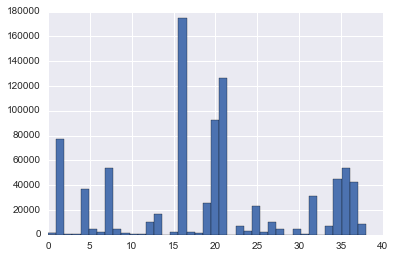

In [11]:
h = plt.hist(ytrain, bins = 39)

### The most popular crimes

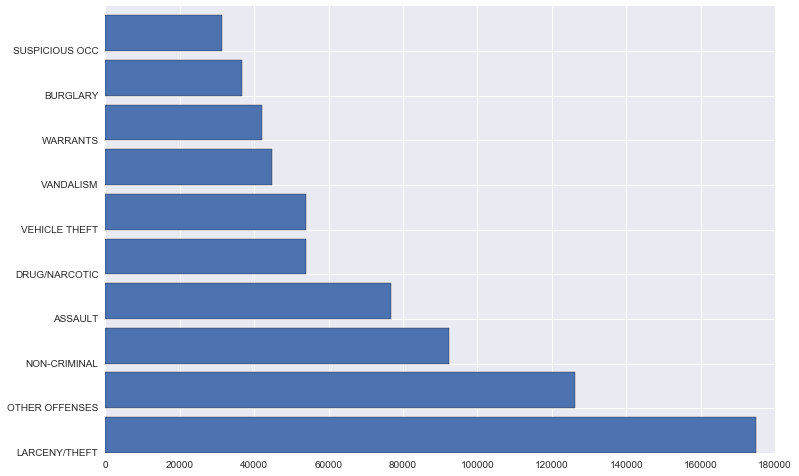

In [12]:
top_crimes = dtrain.Category.value_counts()[:10]
plt.figure(figsize=(12, 8))
pos = np.arange(len(top_crimes))
plt.barh(pos, top_crimes.values);
plt.yticks(pos, top_crimes.index);

In [13]:
 top_crimes.index

Index([u'LARCENY/THEFT', u'OTHER OFFENSES', u'NON-CRIMINAL', u'ASSAULT', u'DRUG/NARCOTIC', u'VEHICLE THEFT', u'VANDALISM', u'WARRANTS', u'BURGLARY', u'SUSPICIOUS OCC'], dtype='object')

### The most criminal locations

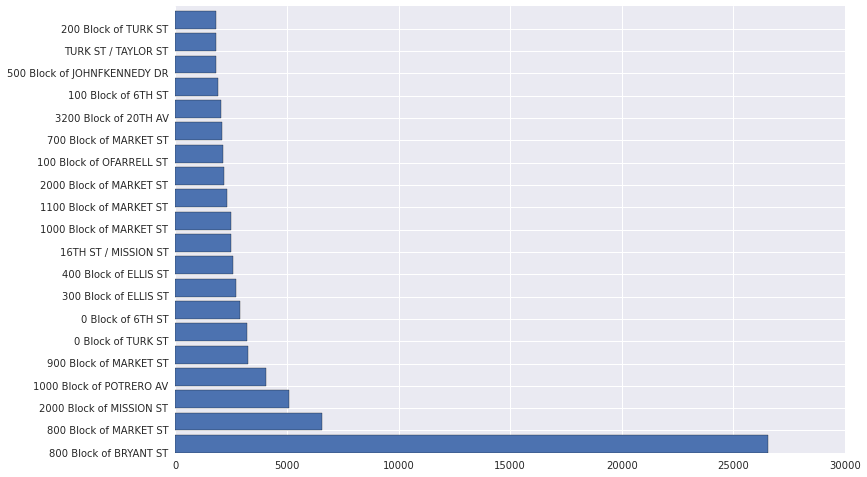

In [103]:
top_addresses = dtrain.Address.value_counts()[:20]
plt.figure(figsize=(12, 8))

pos = np.arange(len(top_addresses))
plt.barh(pos, top_addresses.values)
plt.yticks(pos, top_addresses.index);

### Crimes and locations

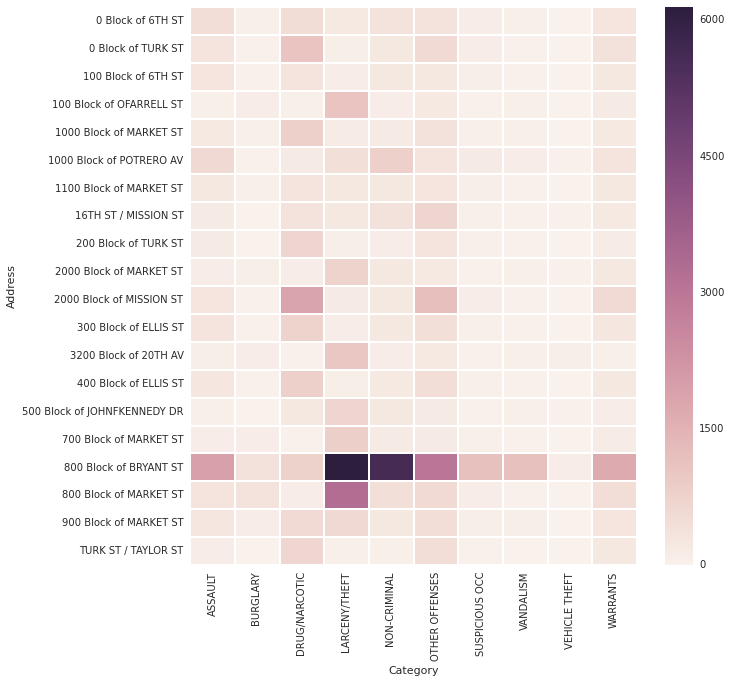

In [104]:
subset = dtrain[dtrain.Address.isin(top_addresses.index) & dtrain.Category.isin(top_crimes.index)]
addr_cross_cat = pd.crosstab(subset.Address, subset.Category)

plt.figure(figsize=(10, 10))
sns.heatmap(addr_cross_cat, linewidths=.5);

In [16]:
dtrain.Category.isin(top_days.index)

array(['Wednesday', 'Tuesday', 'Monday', 'Sunday', 'Saturday', 'Friday',
       'Thursday'], dtype=object)

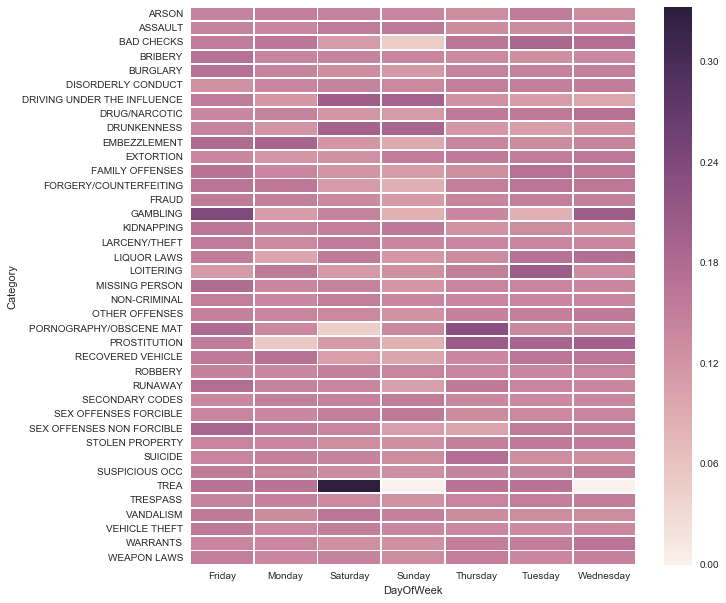

In [29]:
day_cross_cat = pd.crosstab(dtrain.Category, dtrain.DayOfWeek).apply(lambda r: r/r.sum(), axis=1)

plt.figure(figsize=(10, 10))
sns.heatmap(day_cross_cat, linewidths=.9);

### Join distribution of X and Y coordinates

In [105]:
def viz_spatial(x, y, xlim=None, ylim=None):
    x1 = pd.Series(x, name="$X_1$")
    x2 = pd.Series(y, name="$X_2$")

    g = sns.JointGrid(x1, x2, xlim=xlim, ylim=ylim)
    g = g.plot_joint(sns.kdeplot, cmap="Reds_d")
    g = g.plot_marginals(sns.kdeplot, color="r", shade=True)

In [ ]:
num = 10000 #number of samples
rand_idx = random.sample(list(dtrain.index),num)

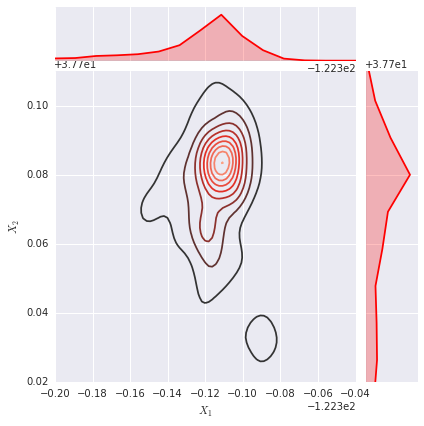

In [106]:
Xtrain_d = Xall[:len(dtrain)]

viz_spatial(Xtrain_d[rand_idx,4], Xtrain_d[rand_idx,5],  xlim=(-122.5, -122.34), ylim=(37.72, 37.81))

## Feature extraction: date features

In [89]:
print("Extracting date features...")

# Preprocessing functions
to_date = np.vectorize(lambda date_str: datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S'))
to_year = np.vectorize(lambda date: date.year)
to_hour = np.vectorize(lambda date: date.hour)
to_minutes_30_abs = np.vectorize(lambda date: abs(date.minute - 30))
to_day = np.vectorize(lambda date: date.day)
to_month = np.vectorize(lambda date: date.month)
closest_center = lambda loc: kmeans.predict(loc)
dist_to_center = lambda loc: kmeans.transform(loc)

Extracting date features...


In [13]:
# Apply all date features
Xall_date = to_date(Xall[:, 0])

In [92]:
year_f = to_year(Xall_date)  # year
hour_f = to_hour(Xall_date) # hour
month_f = to_month(Xall_date) # month
day_f = le_day.transform(Xall[:, 1])
min30_f = to_minutes_30_abs(Xall_date) # minutes - 30

## Feature extraction: extract useful information from raw X and Y coordinates

### Scaling the coordinates

In [42]:
xy_scaler = StandardScaler()
xy_scaler.fit(Xall[:,4:6])
xy_scaled = xy_scaler.transform(Xall[:,4:6])

#### Vizualize scaled coordinates

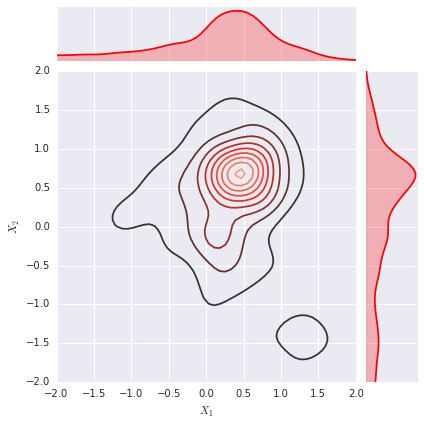

In [64]:
viz_spatial(xy_scaled[rand_idx,0], xy_scaled[rand_idx,1], (-2, 2), (-2, 2))

### Clustering of coordinates

In [48]:
kmeans = KMeans(n_clusters=40, init='k-means++')
kmeans.fit(xy_scaled[1:10000, :]);

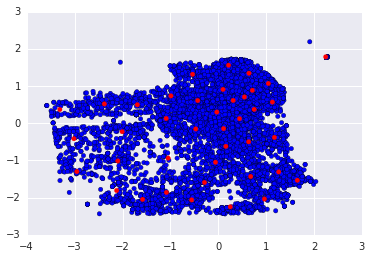

In [49]:
idx = np.random.choice(xy_scaled.shape[0], 10000)
sample = xy_scaled[idx,]
plt.scatter(sample[:,0], sample[:,1]);
plt.scatter(kmeans.cluster_centers_[..., 0], kmeans.cluster_centers_[..., 1], color='red');

In [50]:
closest_centers_f = closest_center(Xall[:, 4:6])

In [51]:
dist_to_centers_f = dist_to_center(Xall[:, 4:6])

### PCA on X and Y

In [54]:
XY_alll = Xall[:,4:6]

In [82]:
XY_PCA = PCA(n_components=2, whiten=True).fit_transform(xy_scaled)

#### Vizualize first 2 components of PCA

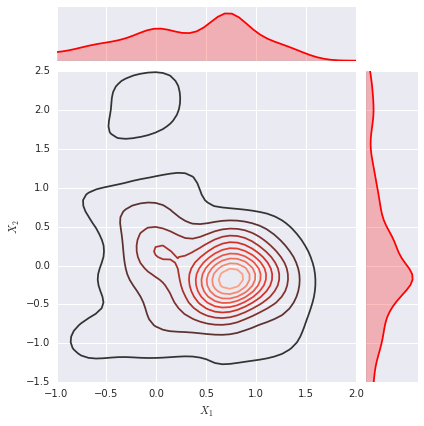

In [84]:
viz_spatial(XY_PCA[rand_idx,0], XY_PCA[rand_idx,1], (-1, 2), (-1.5, 2.5))

In [ ]:
#XY_CCA = CCA(n_components=2).fit(XY_alll[len()], ytrain)

### Rotated carthesian coordinates with rotation

In [78]:
#x = xcos + ysin
#y = ycos - xsin

rot45_X = .707* xy_scaled[:,1] + .707* xy_scaled[:,0] 
rot45_Y = .707* xy_scaled[:,1] - .707* xy_scaled[:,0]

rot30_X = (1.732/2)* xy_scaled[:,0] + (1./2)* xy_scaled[:,1]
rot30_Y = (1.732/2)* xy_scaled[:,1] - (1./2)* xy_scaled[:,0]

rot60_X = (1./2)* xy_scaled[:,0] + (1.732/2)* xy_scaled[:,1] 
rot60_Y = (1./2)* xy_scaled[:,1] - (1.732/2)* xy_scaled[:,0]

### Polar coordinates

In [ ]:
radial_r = np.sqrt( np.power(xy_scaled[:,1],2) + np.power(xy_scaled[:,0],2) )
radial_phi = np.arctan2(xy_scaled[:,1], xy_scaled[:,0])

## Concat all features into one dataset

In [93]:
print("Concatenate all features...")

Xall_dfs = np.column_stack([
        year_f,  # year
        hour_f,  # hour
        month_f, # month
        day_f, #dayweek
        le_pol.transform(Xall[:, 2]), #pd district
        closest_centers_f, #closest cluster center
        dist_to_centers_f,  #distance to other clusters
        XY_PCA,
        rot45_X,
        rot45_Y,
        rot30_X,
        rot30_Y,
        rot60_X,
        rot60_Y,
        radial_r,
        radial_phi,
        min30_f
])

Concatenate all features...


In [95]:
Xall_dfs.shape

(1762311, 57)

## Split all data datasets into original train and test datasets again

In [113]:
# we will use these datasets since now 

Xtrain_d = Xall_dfs[:len(dtrain)]
Xtest_d = Xall_dfs[len(dtrain):]

Xtrain_d.shape, Xtest_d.shape

((878049, 57), (884262, 57))

## Save datasets to h5 file

In [97]:
print("Saving data to h5...")

f = h5py.File("SFData.hdf5", "w")
dt = h5py.special_dtype(vlen=str)
f.create_dataset("X_train", data=Xtrain_d)
f.create_dataset("y_train", data=ytrain)
f.create_dataset("X_test", data=Xtest_d)
f.create_dataset("X_test_ID", data=np.array(dtest.Id.tolist()))
f.create_dataset("le_cat_classes", data=le_cat.classes_, dtype=dt)
f.close()

Saving data to h5...
